In [1]:
%reload_ext autoreload
%autoreload 2

import vtk
from vtk.util import numpy_support

import numpy as np
import bloscpack as bp
import sys
import os

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *

from skimage.measure import marching_cubes, correct_mesh_orientation

from vis3d_utilities import *
from itertools import izip

%matplotlib inline

/usr/lib/python2.7/dist-packages/pkg_resources.py:1031: UserWarning: /home/yuncong/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


In [2]:
mesh_rootdir = create_if_not_exists('/home/yuncong/CSHL_meshes')
volume_dir = '/home/yuncong/CSHL_volumes/'
atlasAlignParams_dir = '/home/yuncong/CSHL_atlasAlignParams/'

In [3]:
volume_landmark_names_unsided = ['12N', '5N', '6N', '7N', '7n', 'AP', 'Amb', 'LC',
                                 'LRt', 'Pn', 'R', 'RtTg', 'Tz', 'VLL', 'sp5']
linear_landmark_names_unsided = ['outerContour']

labels_unsided = volume_landmark_names_unsided + linear_landmark_names_unsided
labels_unsided_indices = dict((j, i+1) for i, j in enumerate(labels_unsided))  # BackG always 0

labelMap_unsidedToSided = {'12N': ['12N'],
                            '5N': ['5N_L', '5N_R'],
                            '6N': ['6N_L', '6N_R'],
                            '7N': ['7N_L', '7N_R'],
                            '7n': ['7n_L', '7n_R'],
                            'AP': ['AP'],
                            'Amb': ['Amb_L', 'Amb_R'],
                            'LC': ['LC_L', 'LC_R'],
                            'LRt': ['LRt_L', 'LRt_R'],
                            'Pn': ['Pn_L', 'Pn_R'],
                            'R': ['R_L', 'R_R'],
                            'RtTg': ['RtTg'],
                            'Tz': ['Tz_L', 'Tz_R'],
                            'VLL': ['VLL_L', 'VLL_R'],
                            'sp5': ['sp5'],
                           'outerContour': ['outerContour']}

labelMap_sidedToUnsided = {n: nu for nu, ns in labelMap_unsidedToSided.iteritems() for n in ns}

from itertools import chain
labels_sided = list(chain(*(labelMap_unsidedToSided[name_u] for name_u in labels_unsided)))
labels_sided_indices = dict((j, i+1) for i, j in enumerate(labels_sided)) # BackG always 0

In [4]:
def align_principle_axes(vertices_normalized0, vertices_normalized):
    
    u1, _, _ = np.linalg.svd(np.dot(vertices_normalized0.T, vertices_normalized0)/vertices_normalized0.shape[0])
    
    u, s, v = np.linalg.svd(np.dot(vertices_normalized.T, vertices_normalized)/vertices_normalized.shape[0])

    if np.dot(u[:,0], u1[:,0]) < 0:
        u[:,0] = -u[:,0]
    if np.dot(u[:,1], u1[:,1]) < 0:
        u[:,1] = -u[:,1]
    if np.dot(u[:,2], u1[:,2]) < 0:
        u[:,2] = -u[:,2]

    U, _, VT = np.linalg.svd(np.dot(u1, u.T))
    R = np.dot(U, VT)
    
    return R

In [61]:
from scipy.spatial import KDTree

def icp(fixed, moving, num_iter=10, rotation_only=True):
    # https://www.wikiwand.com/en/Orthogonal_Procrustes_problem
    # https://www.wikiwand.com/en/Kabsch_algorithm
    
    c_fixed = fixed.mean(axis=0)
    fixed = fixed - c_fixed
    
    moving2 = moving.copy()
    template = fixed.copy()
    
    tree = KDTree(template)

    for i in range(num_iter):
        
        t = time.time()

        c_moving = moving2.mean(axis=0)
        moving2 = moving2 - c_moving

        _, nns = tree.query(moving2)
        data = template[nns]
        M = np.dot(moving2.T, data)
        U, s, VT = np.linalg.svd(M)
        if rotation_only:
            s2 = np.ones_like(s)
            s2[-1] = np.sign(np.linalg.det(np.dot(U, VT).T))
            R = np.dot(np.dot(U, np.diag(s2)), VT).T
        else:
            R = np.dot(U, VT).T
            
        moving2 = np.dot(moving2, R.T)
        d = np.sum(np.sqrt(np.sum((moving2 - data)**2, axis=1)))
        if i > 1 and d_prev == d:
            break
        d_prev = d
        
        sys.stderr.write('icp @ %d err %.2f: %.2f\n' % (i, d, time.time() - t))
    
    c_moving = moving2.mean(axis=0)
    moving2 = moving2 - c_moving
    
    M = np.dot(moving2.T, template[nns])
    U, _, VT = np.linalg.svd(M)
    R = np.dot(U, VT).T

    return R, c_fixed, c_moving

In [6]:
def average_shape(polydata_list, concensus_percentage=.5, num_simplify_iter=0, smooth=False):
    
    volume_list = []
    origin_list = []

    for p in polydata_list:
        t = time.time()
        v, orig, _ = polydata_to_volume(p)
        sys.stderr.write('polydata_to_volume: %.2f\n' % (time.time() - t))

        volume_list.append(v)
        origin_list.append(np.array(orig, np.int))

    t = time.time()
        
    common_mins = np.min(origin_list, axis=0).astype(np.int)
    relative_origins = origin_list - common_mins

    common_xdim, common_ydim, common_zdim = np.max([(v.shape[1]+o[0], v.shape[0]+o[1], v.shape[2]+o[2])
                                                    for v,o in zip(volume_list, relative_origins)], axis=0)

    common_volume_list = []

    for i, v in enumerate(volume_list):
        common_volume = np.zeros( (common_ydim, common_xdim, common_zdim), np.uint8)
        x0, y0, z0 = relative_origins[i]
        ydim, xdim, zdim = v.shape
        common_volume[y0:y0+ydim, x0:x0+xdim, z0:z0+zdim] = v

        common_volume_list.append((common_volume > 0).astype(np.int))

    average_volume = np.sum(common_volume_list, axis=0) >= min(2, len(common_volume_list)*concensus_percentage)
        
    sys.stderr.write('find common: %.2f\n' % (time.time() - t))

    print average_volume.shape
    
    t = time.time()
    average_polydata = volume_to_polydata(average_volume, common_mins, num_simplify_iter=num_simplify_iter, 
                                          smooth=smooth)
    sys.stderr.write('volume_to_polydata: %.2f\n' % (time.time() - t))
    
    return average_volume, average_polydata

fill point array: 0.02 seconds
fill cell array: 0.00 seconds
fill point array: 0.02 seconds
fill cell array: 0.00 seconds
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
non-zero voxels: 3.039471 seconds
load gradient: 5.472436 seconds


outerContour


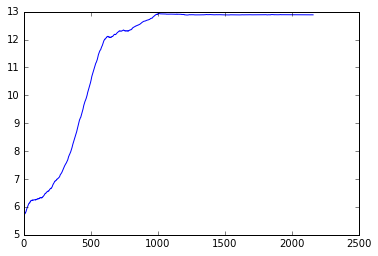

icp: 42.06
fill point array: 0.02 seconds
fill cell array: 0.00 seconds
fill point array: 0.02 seconds
fill cell array: 0.00 seconds


In [57]:
from collections import defaultdict
centroid_allLandmarks = defaultdict(list)
average_polydata_allLandmarks = {}
polydata_list_allLandmarks = {}

# for name_unsided in labels_unsided:
for name_unsided in ['outerContour']:
# for name_unsided in ['12N']:
    
    print name_unsided    
    
    vertices_list = []
    faces_list = []
    
    for stack in ['MD589', 'MD594']:
#     for stack in ['MD594']:

        names = labelMap_unsidedToSided[name_unsided]
        
        if len(names) == 2:
        
            for name_sided in names:

                fn = "/home/yuncong/CSHL_meshes/%(stack)s/%(stack)s_%(label)s_gaussianSmoothed.stl" % {'stack':stack, 'label':name_sided}
               
                if os.path.exists(fn):
                    vertices, faces = load_mesh_stl(fn)
                else:
                    continue
            
                if '_L' in name_sided:
                    zmean = vertices[:,2].mean(axis=0)
                    vertices[:, 2] = - (vertices[:, 2] - zmean) + zmean # mirror L to align with R, keep zmin        

                vertices_list.append(vertices)
                faces_list.append(faces)

        
        elif len(names) == 1:
            
            name_sided = names[0]
            
            fn = "/home/yuncong/CSHL_meshes/%(stack)s/%(stack)s_%(label)s_gaussianSmoothed.stl" % {'stack':stack, 'label':name_sided}
            
            if os.path.exists(fn):
                vertices, faces = load_mesh_stl(fn)
            else:
                continue

            vertices_list.append(vertices)
            faces_list.append(faces)
            
    
    ###### Align meshes ######
    
    u1 = None
    vertices_normalized_aligned_list = []
    vertices_aligned_list = []

    for i, vertices in enumerate(vertices_list):

        if i == 0:
            vertices1 = vertices.copy()
            vol_fixed, origin_fixed, _ = polydata_to_volume(mesh_to_polydata(vertices, faces_list[0]))
            vertices_aligned_list.append(vertices1)
        else:            
            t = time.time()
            
            vol_moving, origin_moving, _ = polydata_to_volume(mesh_to_polydata(vertices, faces_list[i]))
            T, c_fixed, c_moving = optimize_rigid_lieGroup(vol_fixed, vol_moving)
            vertices_alignedTo1 = transform_points(T, vertices-origin_moving, c=c_moving, c_prime=c_fixed) + origin_fixed
            
            R = icp(vertices1, vertices_alignedTo1, num_iter=100)
            
            sys.stderr.write('icp: %.2f\n' % (time.time() - t))

            vertices_aligned_list.append(vertices_alignedTo1)
    
    polydata_list = [mesh_to_polydata(vs, fs) for vs, fs in zip(vertices_aligned_list, faces_list)]
            
    polydata_list_allLandmarks[name_unsided] = polydata_list
    
    ######### Compute Average #########
#     t = time.time()

#     if name_unsided == 'outerContour' or name_unsided == 'sp5':
#         _, average_polydata = average_shape(polydata_list, num_simplify_iter=5, smooth=True)
#     else:
#         _, average_polydata = average_shape(polydata_list, num_simplify_iter=3, smooth=True)
    
#     sys.stderr.write('average shape: %.2f\n' % (time.time() - t))

#     average_polydata_allLandmarks[name_unsided] = average_polydata

#     bp.pack_ndarray_file(average_volume, mesh_rootdir + "/%(name)s_average.bp" % {'stack': stack, 'name': name_unsided})
    
#     save_mesh_stl(average_polydata, mesh_rootdir + "/%(name)s_average.stl" % {'stack': stack, 'name': name_unsided})

centroid_allLandmarks.default_factory = None

In [59]:
name_to_show = 'outerContour'

######## show overlay list of meshes ########
ren1 = vtk.vtkRenderer()
renWin1 = vtk.vtkRenderWindow()
renWin1.AddRenderer(ren1)
iren1 = vtk.vtkRenderWindowInteractor()
iren1.SetRenderWindow(renWin1)

colors = [(0,0,1), (0,1,0), (1,0,0), (1,1,0)]

for i, polydata in enumerate(polydata_list_allLandmarks[name_to_show]):
    
    m = vtk.vtkPolyDataMapper()
    m.SetInputData(polydata)

    a = vtk.vtkActor()
    a.SetMapper(m)
    a.GetProperty().SetRepresentationToWireframe()
    a.GetProperty().SetColor(colors[i % len(colors)])
    
    ren1.AddActor(a)

axes_widget1 = add_axes(iren1)

renWin1.Render()
renWin1.SetWindowName('overlay')

camera = vtk.vtkCamera()
ren1.SetActiveCamera(camera)
ren1.ResetCamera()

iren1.Start()

In [ ]:
name_to_show = 'sp5'

######## show overlay list of meshes ########
ren1 = vtk.vtkRenderer()
renWin1 = vtk.vtkRenderWindow()
renWin1.AddRenderer(ren1)
iren1 = vtk.vtkRenderWindowInteractor()
iren1.SetRenderWindow(renWin1)

colors = [(1,0,0), (0,1,0), (0,0,1), (1,1,0)]

for i, polydata in enumerate(polydata_list_allLandmarks[name_to_show]):
    
    m = vtk.vtkPolyDataMapper()
    m.SetInputData(polydata)

    a = vtk.vtkActor()
    a.SetMapper(m)
    a.GetProperty().SetRepresentationToWireframe()
    a.GetProperty().SetColor(colors[i % len(colors)])
    
    ren1.AddActor(a)

axes_widget1 = add_axes(iren1)

renWin1.Render()
renWin1.SetWindowName('overlay')

######### show average mesh #########
ren2 = vtk.vtkRenderer()

renWin2 = vtk.vtkRenderWindow()
renWin2.AddRenderer(ren2)

iren2 = vtk.vtkRenderWindowInteractor()
iren2.SetRenderWindow(renWin2)

m2 = vtk.vtkPolyDataMapper()
m2.SetInputData(average_polydata_allLandmarks[name_to_show])

a2 = vtk.vtkActor()
a2.SetMapper(m2)
a2.GetProperty().SetRepresentationToWireframe()
# a.GetProperty().SetColor(colors[2])

ren2.AddActor(a2)
axes_widget2 = add_axes(iren2)

renWin2.Render()
renWin2.SetWindowName('average')

#####################################

camera = vtk.vtkCamera()
ren1.SetActiveCamera(camera)
ren2.SetActiveCamera(camera)
ren1.ResetCamera()
ren2.ResetCamera()

iren1.Start()
iren2.Start()